In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from scipy.ndimage import convolve
import matplotlib.animation as animation
import warnings
import scipy

In [6]:
params = {
    "Nh":  10000,
    "N":    10,
    "R0":    4,
    "L":    1,
    "D":     3,
    "dc":    5,
}
sim_params = {
    "xdomain":  100,
    "dx":         1,
    "t0":         0,
    "tf":         10,
    "dt":         0.1,
    "noise_mean": 0,
    "noise_std":  0.1,
}

In [7]:
x_range = sim_params["xdomain"]
dx = sim_params["dx"]
x_linspace = np.arange(-x_range, x_range, dx)
x_size = np.size(x_linspace)
sim_params["x_size"] = x_size

t_size = (sim_params["tf"]-sim_params["t0"])/sim_params["dt"]

s = np.zeros([x_size, x_size])
n = np.zeros([x_size, x_size]) 
h = params["L"]*np.ones([x_size, x_size])/x_size**2
coordmap = np.meshgrid(x_linspace, x_linspace)
c = h.copy()

In [267]:
off_diag = np.ones(x_size**2)
L = scipy.sparse.diags([-1, 5, -1], [-1, 0, 1], shape = (x_size**2, x_size**2)) #Discrete Laplacian Operator L 
L = L.tolil() 
L[0,0] = L[-1,-1] = 3 #Neumann Boundary condition
sim_params["Laplacian"] = L

In [257]:
def P_infection_map(h):
    L = params["L"]
    c = h/L
    return (1-c)**L

In [8]:
def gen_Gaussian_noise(n):
    mean = sim_params["noise_mean"]
    std = sim_params["noise_std"]
    samples = np.random.normal(mean, std, size=n.size)
    return samples.reshape(n.shape)

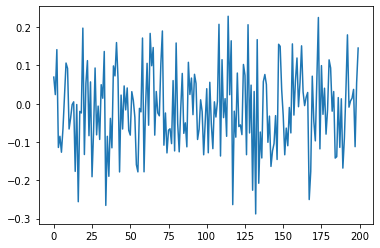

In [10]:
plt.plot(gen_Gaussian_noise(n)[1,:])

In [137]:
n_flat = n.ravel() #ravel is just a pointer change, does not change memory
h_flat = h.ravel() #if you change h, h_flat doesn't change, opposite is not true

In [258]:
def step_n_approx(n, h):
    R0 = params["R0"]
    D = params["D"]
    drive = np.log(R0 * P_infection_map(h))
    approx_del2 = scipy.ndimage.filters.laplace(n) #Dumb Way to approximate Laplacian
    
    noise = np.sqrt(n)*gen_Gaussian_noise(n)
     
    return drive*n + D*approx_del2 + noise

In [261]:
def step_n_exact(n, h):
    R0 = params["R0"]
    D = params["D"]
    drive = np.log(R0 * P_infection_map(h))
    L = sim_params["Laplacian"].tocsr() #more exact way to do Laplacian
    
    if n.ndim != 1:
        del2n = L.dot(n.ravel()).reshape(n.shape)
    else:
        del2n = L.dot(n)

    
    noise = np.sqrt(n)*gen_Gaussian_noise(n)
     
    return drive*n + D*del2n + noise

In [174]:
def step_h(n, h):
    Nh = params["Nh"]
    N = np.sum(n) 
    # N = params["N"] #fixed N
    L = params["L"]
    h_new = (1/Nh)*(n - (h/L)*N) 
    return h_new

In [11]:
initial_position = sim_params["initial_mean"] = [0, 0]
initial_var = sim_params["initial_var"] = 1

x_map = coordmap[0]
y_map = coordmap[1]

rsqrd = (x_map-initial_position[0])**2 + (y_map-initial_position[0])**2

n0 = np.exp(-rsqrd/(2*(initial_var**2)))
norm = np.sum(n0)
n0 = n0/np.sum(n0) # initial cond for n: Gaussian dist

h0 = params["L"]*np.ones(h.shape)/np.size(h) # Initial condition for h0: Uniform dist

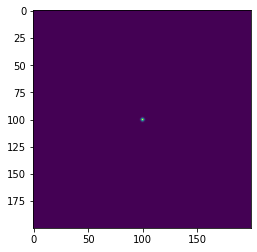

In [171]:
plt.imshow(n0)

In [12]:
h = h0
n = n0
t_start = sim_params["t0"]
t_stop = sim_params["tf"]
t_step = sim_params["dt"]

frames_n = []
fig = plt.figure()

with warnings.catch_warnings():
    warnings.filterwarnings('error')
    try:
        for t in np.arange(t_start, t_stop, t_step):

            n = n + step_n_exact(n, h)*(t_step/2) #Half-step first for n: n(t+dt/2) = n(t) + dn/dt(t)*(dt/2)
            n[n < 0] = 0
            h = h + step_h(n,h)*(t_step/2) #Half-step for h
 
            n = n + step_n_exact(n, h)*(t_step/2) #Second Half-step for n : n(t+dt) = n(t+dt/2) + dn/dt(t+dt/2)*(dt/2)
            n[n<0] =0
            h = h + step_h(n, h)*(t_step/2) #Second Half-step for h

            frames_n.append([plt.imshow(n, animated = True)])
    except Warning as e:
        print('error type:', e)
        print("error found at:", t)

        plt.imshow(n)


ani = animation.ArtistAnimation(fig, frames_n, interval=50, blit=True, repeat_delay=1000)
ani.save("test.gif")
plt.show()

NameError: name 'step_n_exact' is not defined

<Figure size 432x288 with 0 Axes>

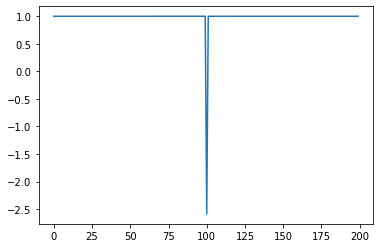

In [276]:
plt.plot(P_infection_map(h)[100,:])

In [284]:
np.sum(h0)

1.0000000000000004

In [186]:
h = h0
n = n0
n = n + step_n_exact(n, h)*(t_step/2) #Half-step first for n: n(t+dt/2) = n(t) + dn/dt(t)*(dt/2)
h = h + step_h(n,h)*(t_step) #Half-step for h
n = n + step_n_exact(n, h)*(t_step/2) #Second Half-step for n : n(t+dt) = n(t+dt/2) + dn/dt(t+dt/2)*(dt/2)

/var/folders/9_/htwk2tpd6tv_fy1sp81nfcsm0000gn/T/ipykernel_21909/4010696909.py:12: RuntimeWarning: invalid value encountered in sqrt
  noise = np.sqrt(n)*gen_Gaussian_noise(n)


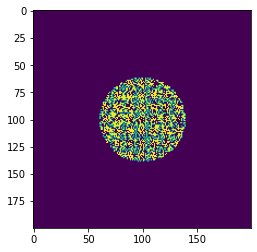

In [195]:
h = h0
n = n0
n = n + step_n_exact(n, h)*(t_step/2) #Half-step first for n: n(t+dt/2) = n(t) + dn/dt(t)*(dt/2
# plt.imshow(n < 0)


drive = np.log(4 * P_infection_map(h, params))

L = sim_params["Laplacian"].tocsr() #more exact way to do Laplacian
del2n = L.dot(n.ravel()).reshape(n.shape)

plt.imshow(del2n<0)

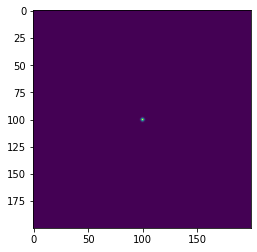

In [196]:
plt.figure()
plt.imshow(n0)

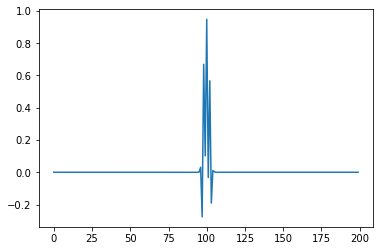

In [203]:
plt.plot(del2n[100,:])